(cobweb)=
# 蛛网模型

蛛网模型是一个描述特定市场中价格和数量及其随时间演变的模型。

## 概述

蛛网模型可以追溯到20世纪30年代，虽然简单，但它仍然具有重要意义，因为它展示了*预期*的根本重要性。

为了说明模型如何运作以及为什么预期很重要，想象以下场景：

有一个大豆市场，价格和交易数量取决于买家和卖家的选择。买家由需求曲线表示——在低价时购买更多，高价时购买更少。卖家有一条供应曲线——他们希望在高价时卖出更多，低价时卖出更少。

然而，卖家（农民）需要时间来种植作物。假设现在价格很高。看到这个高价，可能预期高价会持续一段时间，农民在许多田地里种植大豆。

下一个周期，由此产生的高供应量充斥市场，导致价格下跌。看到这个低价，农民现在减少大豆种植，限制供应，导致价格再次上涨。

你可以想象这种动态如何导致价格和数量的周期性波动持续一段时间。

蛛网模型将这些想法转化为方程，这样我们就可以尝试量化它们，并研究周期持续（或消失）的条件。

在本讲座中，我们将在不同的生产者形成预期的假设下调查和模拟基本模型。

我们的讨论和模拟借鉴了[Cars Hommes](https://www.uva.nl/en/profile/h/o/c.h.hommes/c.h.hommes.html)的[高质量讲座](https://comp-econ.org/CEF_2013/downloads/Complex%20Econ%20Systems%20Lecture%20II.pdf)。

我们将使用以下导入。

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mpl
FONTPATH = "fonts/SourceHanSerifSC-SemiBold.otf"
mpl.font_manager.fontManager.addfont(FONTPATH)
plt.rcParams['font.family'] = ['Source Han Serif SC']

## 历史

关于蛛网循环的早期论文包括{cite}`cobweb_model`和{cite}`hog_cycle`。
论文{cite}`hog_cycle`使用蛛网定理解释了1920年至1950年间美国猪肉价格的变化。
下一个图表复制了该论文中图2的一部分，展示了年度猪肉价格。
注意价格动态的周期性变化，这与上文讨论的大豆价格动态的周期性变化相匹配。

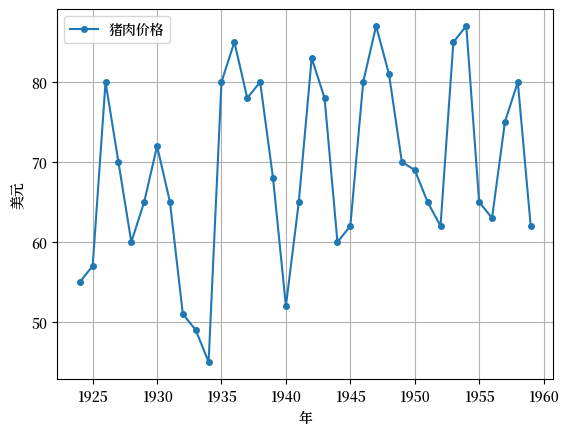

In [2]:
hog_prices = [55, 57, 80, 70, 60, 65, 72, 65, 51, 49, 45, 80, 85,
              78, 80, 68, 52, 65, 83, 78, 60, 62, 80, 87, 81, 70,
              69, 65, 62, 85, 87, 65, 63, 75, 80, 62]
years = np.arange(1924, 1960)
fig, ax = plt.subplots()
ax.plot(years, hog_prices, '-o', ms=4, label='猪肉价格')
ax.set_xlabel('年')
ax.set_ylabel('美元')
ax.legend()
ax.grid()
plt.show()

## 模型

让我们回到讨论假设的大豆市场，其中价格由供需决定。

我们假设大豆的需求由以下公式给出：

$$
    D(p_t) = a - b p_t
$$

其中 $a, b$ 是非负常数，$p_t$ 是 $t$ 时刻的现货（即当前市场）价格。
（$D(p_t)$ 是以某个固定单位表示的需求量，如千吨。）

由于 $t$ 时刻的大豆作物是在 $t-1$ 时种植的，$t$ 时刻的大豆供应取决于 $t$ 时刻的*预期*价格，我们用 $p^e_t$ 表示。

我们假设供应对预期价格是非线性的，并采用以下形式：

$$
    S(p^e_t) = \tanh(\lambda(p^e_t - c)) + d
$$

其中 $\lambda$ 是正常数，$c, d$ 是非负常数，$\tanh$ 是一种[双曲函数](https://en.wikipedia.org/wiki/Hyperbolic_functions)。

让我们为特定参数值选择绘制供需图。

首先，我们将参数存储在一个类中，并将上述函数定义为方法。

In [3]:
class Market:

    def __init__(self,
                 a=8,      # 需求参数
                 b=1,      # 需求参数
                 c=6,      # 供给参数
                 d=1,      # 供给参数
                 λ=2.0):   # 供给参数
        self.a, self.b, self.c, self.d = a, b, c, d
        self.λ = λ

    def demand(self, p):
        a, b = self.a, self.b
        return a - b * p

    def supply(self, p):
        c, d, λ = self.c, self.d, self.λ
        return np.tanh(λ * (p - c)) + d

现在让我们来绘制。

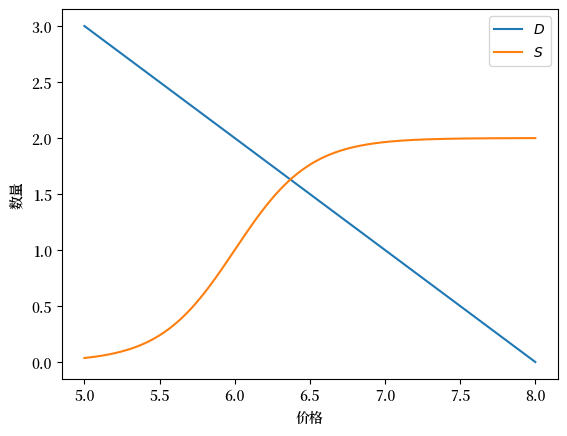

In [4]:
p_grid = np.linspace(5, 8, 200)
m = Market()
fig, ax = plt.subplots()

ax.plot(p_grid, m.demand(p_grid), label="$D$")
ax.plot(p_grid, m.supply(p_grid), label="$S$")
ax.set_xlabel("价格")
ax.set_ylabel("数量")
ax.legend()

plt.show()

市场均衡要求供给等于需求，即
$$
    a - b p_t = S(p^e_t)
$$
用$p_t$重写可得
$$
    p_t = - \frac{1}{b} [S(p^e_t) - a]
$$
最后，为了完成这个模型，我们需要描述价格预期是如何形成的。
我们假设t时刻的预期价格取决于过去的价格。
特别地，我们假设

```{math}
:label: p_et
    p^e_t = f(p_{t-1}, p_{t-2})
```

其中$f$是某个函数。
因此，我们假设生产者预期t时刻的价格是滞后价格的某个函数，最多滞后2期。
（当然，我们可以添加更多的滞后期，鼓励读者尝试这样的情况。）
结合最后两个等式，我们得到价格的动态方程：

```{math}
:label: price_t
    p_t = - \frac{1}{b} [ S(f(p_{t-1}, p_{t-2})) - a]
```
价格动态取决于参数值以及决定生产者如何形成预期的函数 $f$。

## 简单预期

为了进一步分析，我们需要指定函数 $f$；也就是说，预期是如何形成的。

让我们从简单预期开始，它指的是生产者预期下一期的现货价格将是当前期的价格。

换句话说，

$$ 
p_t^e = p_{t-1} 
$$

使用方程 {eq}`price_t`，我们得到

$$
    p_t = - \frac{1}{b} [ S(p_{t-1}) - a]
$$

我们可以将其写为

$$
    p_t = g(p_{t-1})
$$

其中 $g$ 是由以下定义的函数

```{math}
:label: def_g
    g(p) = - \frac{1}{b} [ S(p) - a]
```

这里我们来表示函数$g$。

In [5]:
def g(model, current_price):
    """
  给定当前价格和市场模型，用于找到下一个价格的函数
    """
    a, b = model.a, model.b
    next_price = - (model.supply(current_price) - a) / b
    return next_price

让我们尝试使用 45 度图来理解价格将如何演变，这是研究一维动态的工具。
下面定义的函数 `plot45` 帮助我们绘制 45 度图。

In [6]:
def plot45(model, pmin, pmax, p0, num_arrows=5):
    """
    绘制 45 度图的函数
    参数
    ==========
    model: 市场模型
    pmin: 价格下限
    pmax: 价格上限
    p0: 价格初始值（用于模拟价格）
    num_arrows: 要绘制的模拟次数
    """
    pgrid = np.linspace(pmin, pmax, 200)

    fig, ax = plt.subplots()
    ax.set_xlim(pmin, pmax)
    ax.set_ylim(pmin, pmax)

    hw = (pmax - pmin) * 0.01
    hl = 2 * hw
    arrow_args = dict(fc="k", ec="k", head_width=hw,
            length_includes_head=True, lw=1,
            alpha=0.6, head_length=hl)

    ax.plot(pgrid, g(model, pgrid), 'b-',
            lw=2, alpha=0.6, label='g')
    ax.plot(pgrid, pgrid, lw=1, alpha=0.7, label='$45\degree$')

    x = p0
    xticks = [pmin]
    xtick_labels = [pmin]

    for i in range(num_arrows):
        if i == 0:
            ax.arrow(x, 0.0, 0.0, g(model, x),
                     **arrow_args)
        else:
            ax.arrow(x, x, 0.0, g(model, x) - x,
                     **arrow_args)
            ax.plot((x, x), (0, x), ls='dotted')

        ax.arrow(x, g(model, x),
                 g(model, x) - x, 0, **arrow_args)
        xticks.append(x)
        xtick_labels.append(r'$p_{}$'.format(str(i)))

        x = g(model, x)
        xticks.append(x)
        xtick_labels.append(r'$p_{}$'.format(str(i+1)))
        ax.plot((x, x), (0, x), '->', alpha=0.5, color='orange')

    xticks.append(pmax)
    xtick_labels.append(pmax)
    ax.set_ylabel(r'$p_{t+1}$')
    ax.set_xlabel(r'$p_t$')
    ax.set_xticks(xticks)
    ax.set_yticks(xticks)
    ax.set_xticklabels(xtick_labels)
    ax.set_yticklabels(xtick_labels)

    bbox = (0., 1.04, 1., .104)
    legend_args = {'bbox_to_anchor': bbox, 'loc': 'upper right'}

    ax.legend(ncol=2, frameon=False, **legend_args, fontsize=14)
    plt.show()

现在我们可以设置一个市场并绘制 45 度图。

In [7]:
m = Market()

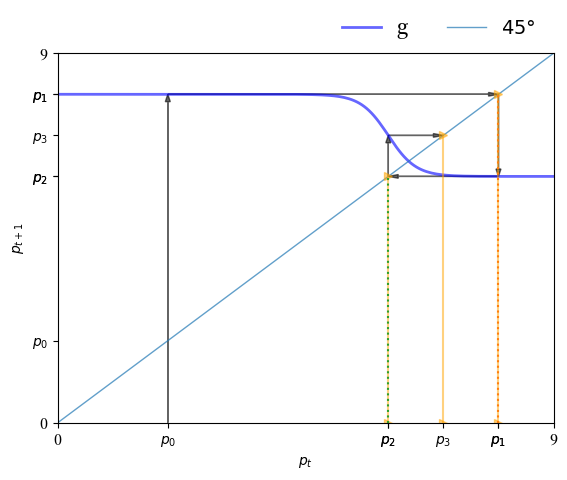

In [8]:
plot45(m, 0, 9, 2, num_arrows=3)

图表显示了方程 {eq}`def_g` 中定义的函数 $g$ 和 45 度线。

将 $p_t$ 视为横轴上的值。

由于 $p_{t+1} = g(p_t)$，我们使用 $g$ 的图形在纵轴上看到 $p_{t+1}$。

显然，
- 如果 $g$ 在 $p_t$ 处位于 45 度线上方，那么我们有 $p_{t+1} > p_t$。
- 如果 $g$ 在 $p_t$ 处位于 45 度线下方，那么我们有 $p_{t+1} < p_t$。
- 如果 $g$ 在 $p_t$ 处与 45 度线相交，那么我们有 $p_{t+1} = p_t$，所以 $p_t$ 是一个稳态。

考虑从 $p_0$ 开始的价格序列，如图所示。

我们在纵轴上找到 $p_1$，然后使用 45 度线（两个轴上的值相等）将其移到横轴上。

然后从 $p_1$ 得到 $p_2$ 并继续。

我们可以看到一个循环的开始。

为了确认这一点，让我们绘制一个时间序列图。

In [9]:
def ts_plot_price(model,             # 市场模型
                  p0,                # 初始价格
                  y_a=3, y_b= 12,    # 控制 y-轴
                  ts_length=10):     # 时间序列的长度
    """
    用来模拟和绘制价格时间序列的函数

    """
    fig, ax = plt.subplots()
    ax.set_xlabel(r'$t$', fontsize=12)
    ax.set_ylabel(r'$p_t$', fontsize=12)
    p = np.empty(ts_length)
    p[0] = p0
    for t in range(1, ts_length):
        p[t] = g(model, p[t-1])
    ax.plot(np.arange(ts_length),
            p,
            'bo-',
            alpha=0.6,
            lw=2,
            label=r'$p_t$')
    ax.legend(loc='best', fontsize=10)
    ax.set_ylim(y_a, y_b)
    ax.set_xticks(np.arange(ts_length))
    plt.show()

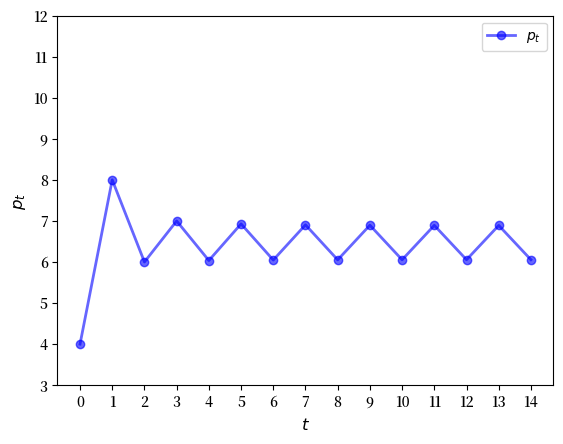

In [10]:
ts_plot_price(m, 4, ts_length=15)

我们看到一个循环已经形成，而且这个循环是持续的。（您可以通过绘制更长时间范围的图表来确认这一点。）

这个循环是"稳定的"，意味着从大多数起始条件开始，价格都会收敛到这个循环。
例如，

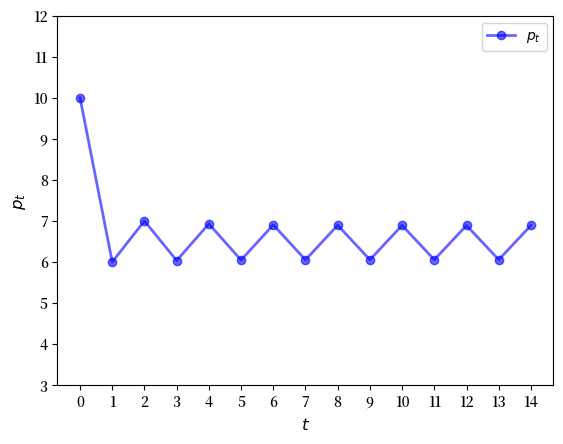

In [11]:
ts_plot_price(m, 10, ts_length=15)

## 适应性预期

朴素预期相当简单，也在我们发现的周期中起着重要的驱动作用。

如果预期以不同的方式形成会怎样？

接下来我们考虑适应性预期。

这指的是生产者对下一期价格的预期形成是基于他们上一次猜测和当前现货价格的加权平均。

也就是说，

```{math}
:label: pe_adaptive
p_t^e = \alpha p_{t-1} + (1-\alpha) p^e_{t-1}
\qquad (0 \leq \alpha \leq 1)
```

另一种写法为

```{math}
:label: pe_adaptive_2
p_t^e = p^e_{t-1} + \alpha (p_{t-1} - p_{t-1}^e)
```

这个方程有助于说明预期会在以下情况下发生变化：
1. 当上一期价格高于预期时，预期上调
1. 当上一期价格低于预期时，预期下调

使用{eq}`pe_adaptive`，我们得到以下动态方程：

$$
    p_t = - \frac{1}{b} [ S(\alpha p_{t-1} + (1-\alpha) p^e_{t-1}) - a]
$$

让我们尝试模拟价格，并观察在不同$\alpha$值下的动态变化。

In [12]:
def find_next_price_adaptive(model, curr_price_exp):
    """
   给定当前价格预期和市场模型，计算下一个价格的函数
    """
    return - (model.supply(curr_price_exp) - model.a) / model.b

下面的函数将在不同的$\alpha$值下绘制适应性预期下的价格动态。

In [13]:
def ts_price_plot_adaptive(model, p0, ts_length=10, α=[1.0, 0.9, 0.75]):
    fig, axs = plt.subplots(1, len(α), figsize=(12, 5))
    for i_plot, a in enumerate(α):
        pe_last = p0
        p_values = np.empty(ts_length)
        p_values[0] = p0
        for i in range(1, ts_length):
            p_values[i] = find_next_price_adaptive(model, pe_last)
            pe_last = a*p_values[i] + (1 - a)*pe_last

        axs[i_plot].plot(np.arange(ts_length), p_values)
        axs[i_plot].set_title(r'$\alpha={}$'.format(a))
        axs[i_plot].set_xlabel('t')
        axs[i_plot].set_ylabel('价格')
    plt.show()

让我们调用这个函数，初始价格设为$p_0 = 5$。

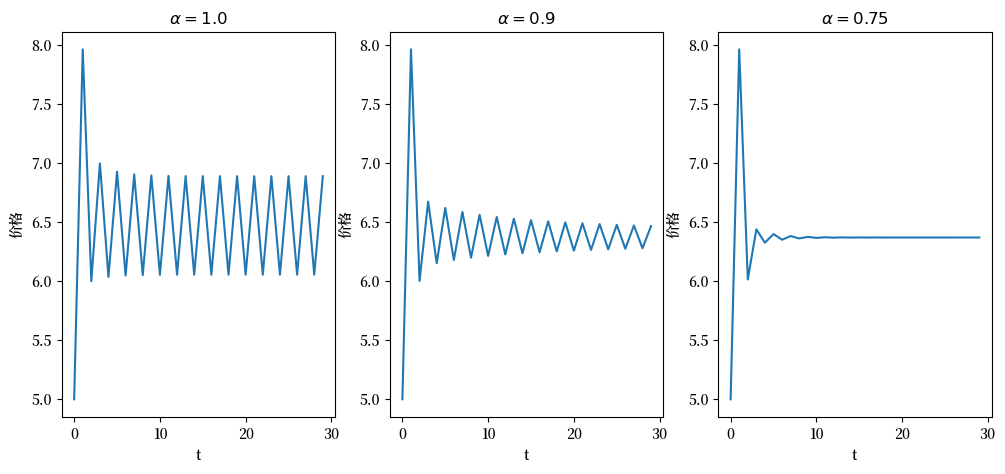

In [14]:
ts_price_plot_adaptive(m, 5, ts_length=30)

请注意，如果$\alpha=1$，那么适应性预期就等同于朴素预期。
减小$\alpha$的值会使更多权重转移到先前的预期上，这会稳定预期价格。
这种增加的稳定性可以在图表中看出。

## 练习

```{exercise-start}
:label: cobweb_ex1
```
使用默认的`Market`类和简单的预期，绘制一个供给（而不是价格）的时间序列模拟。
特别展示供给也会循环变化。

```{exercise-end}
```

```{solution-start} cobweb_ex1
:class: dropdown
```

In [15]:
def ts_plot_supply(model, p0, ts_length=10):
    """
    给定初始价格，模拟和绘制供给函数的函数。
    """
    pe_last = p0
    s_values = np.empty(ts_length)
    for i in range(ts_length):
        # 库存数量
        s_values[i] = model.supply(pe_last)
        # 更新价格
        pe_last = - (s_values[i] - model.a) / model.b


    fig, ax = plt.subplots()
    ax.plot(np.arange(ts_length),
            s_values,
            'bo-',
            alpha=0.6,
            lw=2,
            label=r'supply')

    ax.legend(loc='best', fontsize=10)
    ax.set_xticks(np.arange(ts_length))
    ax.set_xlabel("时间")
    ax.set_ylabel("数量")
    plt.show()

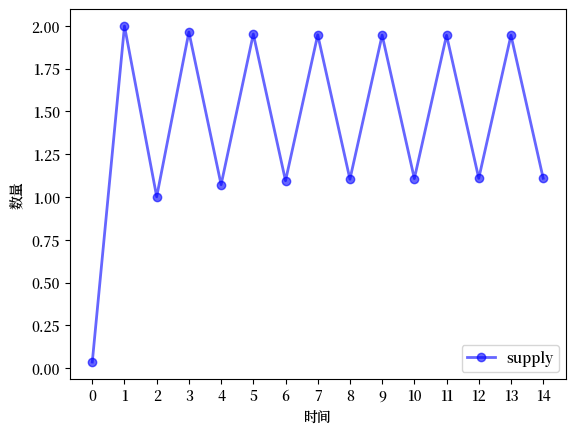

In [16]:
m = Market()
ts_plot_supply(m, 5, 15)

```{solution-end}
```

```{exercise-start}
:label: cobweb_ex2
```
**回顾性平均预期**

回顾性平均预期是指生产者对下一期价格的预期形成为他们最后一次猜测和倒数第二次猜测的线性组合。

也就是说，

```{math}
:label: pe_blae
p_t^e = \alpha p_{t-1} + (1-\alpha) p_{t-2}
```


模拟并绘制 $\alpha \in \{0.1, 0.3, 0.5, 0.8\}$ 时的价格动态，其中 $p_0=1$ 且 $p_1=2.5$。

```{exercise-end}
```

```{solution-start} cobweb_ex2
:class: dropdown
```

In [17]:
def find_next_price_blae(model, curr_price_exp):
    """
    给定当前价格预期和市场模型，找出下一个价格的函数。
    """
    return - (model.supply(curr_price_exp) - model.a) / model.b

In [18]:
def ts_plot_price_blae(model, p0, p1, alphas, ts_length=15):
    """
   使用回顾性平均预期模拟并绘制价格时间序列的函数。
    """
    fig, axes = plt.subplots(len(alphas), 1, figsize=(8, 16))

    for ax, a in zip(axes.flatten(), alphas):
        p = np.empty(ts_length)
        p[0] = p0
        p[1] = p1
        for t in range(2, ts_length):
            pe = a*p[t-1] + (1 - a)*p[t-2]
            p[t] = -(model.supply(pe) - model.a) / model.b
        ax.plot(np.arange(ts_length),
                p,
                'o-',
                alpha=0.6,
                label=r'$\alpha={}$'.format(a))
        ax.legend(loc='best', fontsize=10)
        ax.set_xlabel(r'$t$', fontsize=12)
        ax.set_ylabel(r'$p_t$', fontsize=12)
    plt.show()

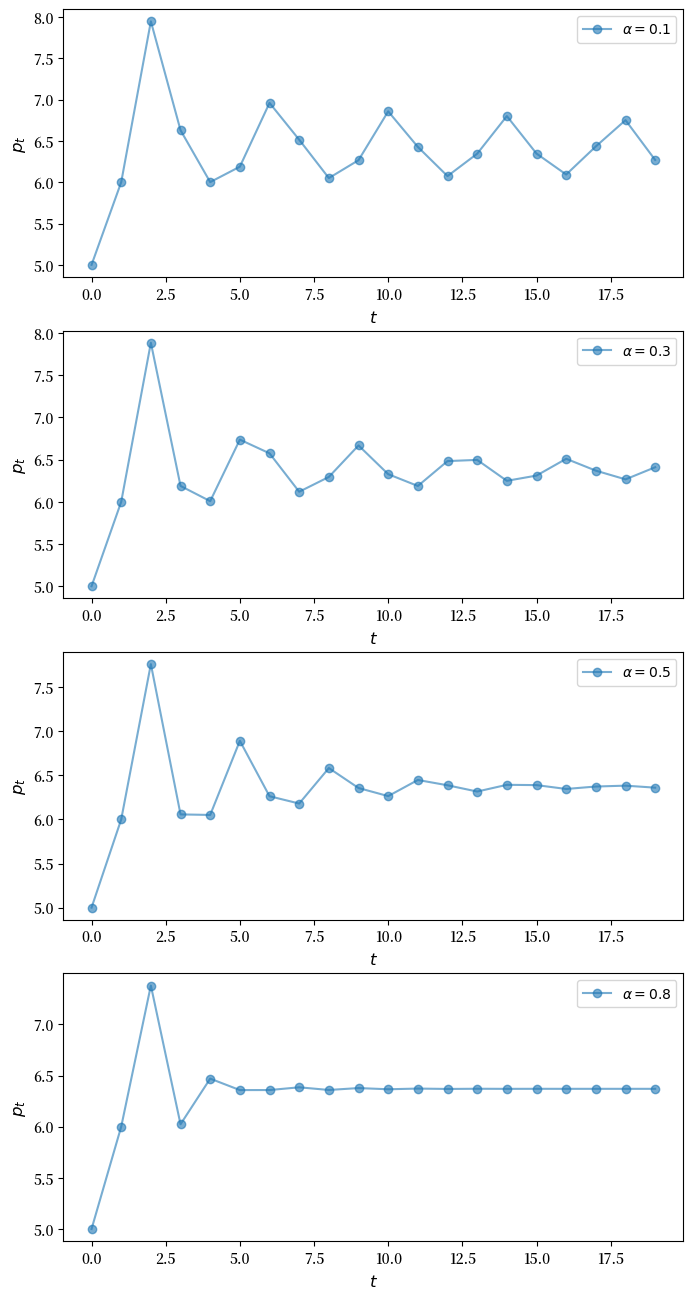

In [19]:
m = Market()
ts_plot_price_blae(m, 
                   p0=5, 
                   p1=6, 
                   alphas=[0.1, 0.3, 0.5, 0.8], 
                   ts_length=20)

```{solution-end}
```